In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import numpy as np
from astropy.table import QTable
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
plt.style.use(astropy_mpl_style)

In [2]:
ravetable = QTable.read('NEW_rave_tgas_query.csv', format='csv')

In [3]:
#Assigning columns in the data table to variable names

pmra = ravetable['pmRA_TGAS']
pmde = ravetable['pmDE_TGAS']
ra_tgas = ravetable['RA_TGAS']
dec_tgas = ravetable['DE_TGAS']
hrv = ravetable['HRV']
plx_tgas = ravetable['parallax_TGAS']
pmra_cosde = pmra * np.cos(dec_tgas)

In [4]:
#Adjusting between arcseconds and milliarcseconds

pmra = pmra * 0.001
pmde = pmde * 0.001
plx_tgas = plx_tgas * 0.001

In [5]:
#Constants for progressing into galactocentric coordinates

rangp = np.radians(192.8583)
decngp = np.radians(27.1280559)
theta0 = np.radians(122.93191857)
k = 4.704057

In [32]:
c_icrs = SkyCoord(ra=ra_tgas*u.degree, dec=dec_tgas*u.degree, distance=plx_tgas*u.mas)
c_icrs = c_icrs.galactic
c_icrs

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, mas)
    [(265.98427177,  26.52057856, 0.00995839),
     (264.50611724,  27.43698235, 0.00820644),
     (264.2645864 ,  27.71266526, 0.00681576), ...,
     (227.49589594, -31.86027977, 0.0036178 ),
     (267.88682657,  34.15661998, 0.00771832),
     (270.29393672,  31.15320946, 0.00529338)]>

In [33]:
ucrd = c_icrs.l
vcrd = c_icrs.b
wcrd = c_icrs.distance

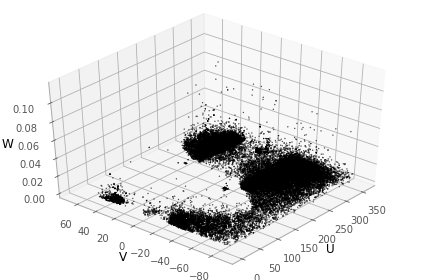

In [8]:
#Plotting new galactocentric coordinates in 3D velocity space.

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_zlabel("W")

ax.scatter((ucrd), (vcrd), (wcrd), c = 'k', s=0.1, alpha=1);
ax.view_init(azim = -140, elev = 40);

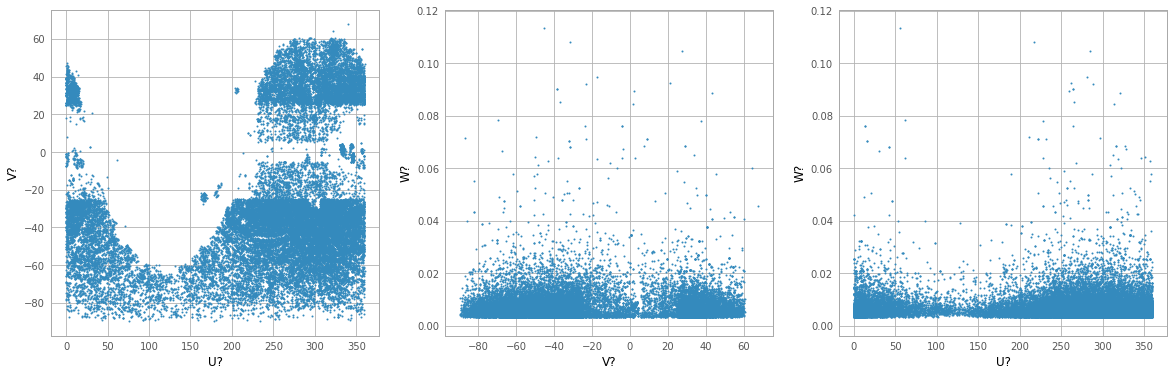

In [9]:
fig, ax = plt.subplots(1,3);
fig.set_size_inches(20,6)


ax[0].set_xlabel("U?")
ax[0].set_ylabel("V?")

ax[1].set_xlabel("V?")
ax[1].set_ylabel("W?")

ax[2].set_xlabel("U?")
ax[2].set_ylabel("W?")

ax[0].scatter(ucrd, vcrd, s=1);
ax[1].scatter(vcrd, wcrd, s=1);
ax[2].scatter(ucrd, wcrd, s=1);

In [6]:
c_icrs = SkyCoord(ra=ra_tgas*u.degree, dec=dec_tgas*u.degree, 
                  distance=(plx_tgas*u.mas).to(u.pc, u.parallax()),
                  pm_ra_cosdec=pmra_cosde*u.mas/u.yr,
                  pm_dec=pmde*u.mas/u.yr,
                  radial_velocity=hrv*u.km/u.s)
d_icrs = c_icrs.galactic

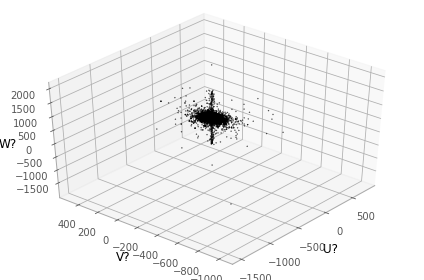

In [7]:
ucord = d_icrs.pm_l_cosb*u.yr/u.mas
vcord = d_icrs.pm_b*u.yr/u.mas
wcord = d_icrs.radial_velocity*u.s/u.km


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("U?")
ax.set_ylabel("V?")
ax.set_zlabel("W?")

ax.scatter(ucord, vcord, wcord, c = 'k', s=0.1, alpha=1);
ax.view_init(azim = -140, elev = 40);

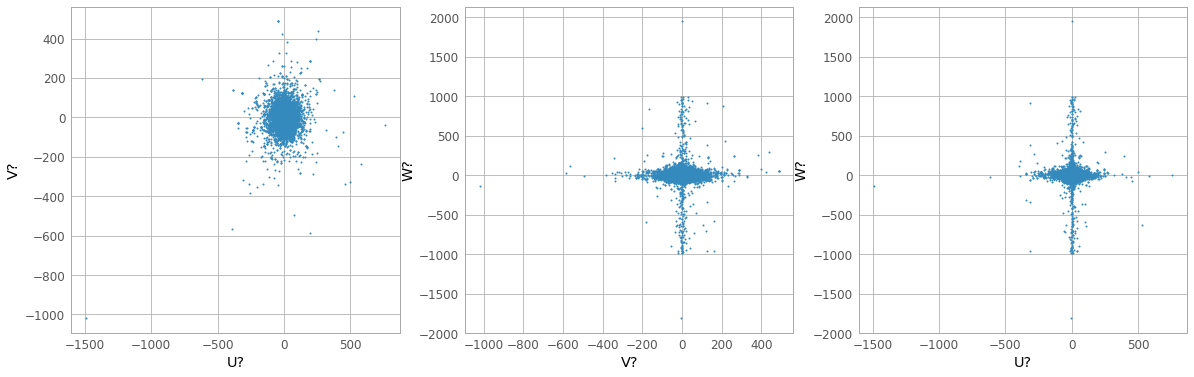

In [47]:
fig, ax = plt.subplots(1,3);
fig.set_size_inches(20,6)


ax[0].set_xlabel("U?")
ax[0].set_ylabel("V?")

ax[1].set_xlabel("V?")
ax[1].set_ylabel("W?")

ax[2].set_xlabel("U?")
ax[2].set_ylabel("W?")

ax[0].scatter(ucord, vcord, s=1);
ax[1].scatter(vcord, wcord, s=1);
ax[2].scatter(ucord, wcord, s=1);

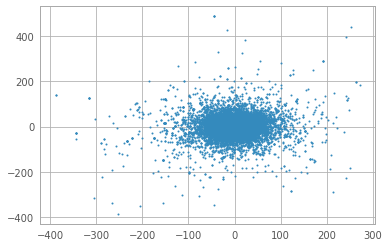

In [8]:
uvmask = np.where((ucord < 300) & (ucord > -500) & (vcord < 500) & (vcord > -400) & (wcord < 600) & (wcord > -600))

ushort = ucord[uvmask]
vshort = vcord[uvmask]
wshort = wcord[uvmask]

uveryshort = ushort
vveryshort = vshort
wveryshort = wshort

vsarray = np.array([uveryshort, vveryshort, wveryshort]).T
#fullarray = np.vstack((ushort.data,vshort.data)).T

plt.scatter(uveryshort, vveryshort, s=1);

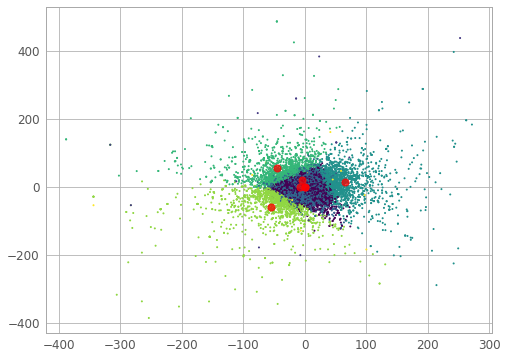

In [73]:
#Initial attempt at applying k-means to the dataset. Not sure if I should 
# be using more or less clusters, or using more or less of the dataset.

kmeans = KMeans(n_clusters=7)
kmeans.fit(vsarray)
y_kmeans = kmeans.predict(vsarray)

plt.scatter(vsarray[:, 0], vsarray[:, 1], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75);

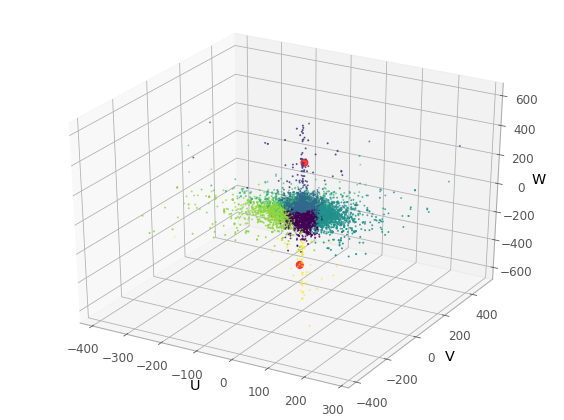

In [74]:
#3D plot of newly implemented random data subsample.

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_zlabel("W")

ax.scatter(vsarray[:, 0], vsarray[:, 1], vsarray[:, 2], c=y_kmeans, s=1, cmap='viridis');
#ax.view_init(azim = -140, elev = 40);
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=50, alpha=0.75);

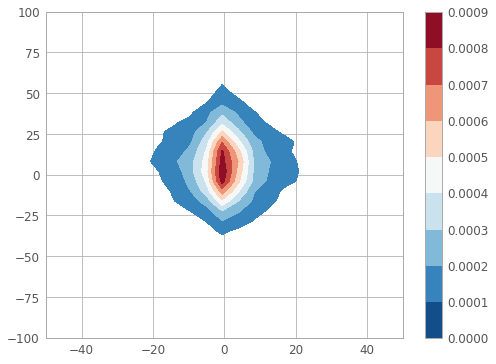

In [76]:
#Kernel density estimate plot of V vs W

sns.kdeplot(vshort, wshort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.ylim([-100,100])
plt.xlim([-50,50])
plt.show()

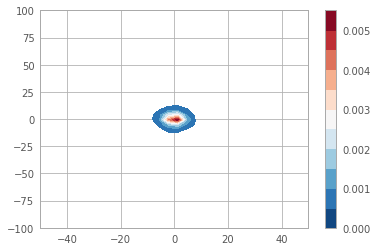

In [9]:
#Kernel density estimate plot of V vs W

sns.kdeplot(ushort, vshort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.ylim([-100,100])
plt.xlim([-50,50])
plt.show()

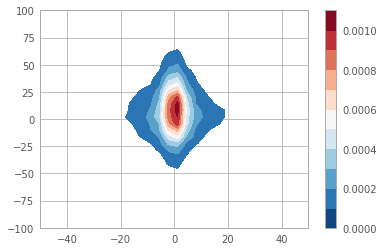

In [13]:
#Kernel density estimate plot of V vs W

sns.kdeplot(ushort, wshort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.ylim([-100,100])
plt.xlim([-50,50])
plt.show()

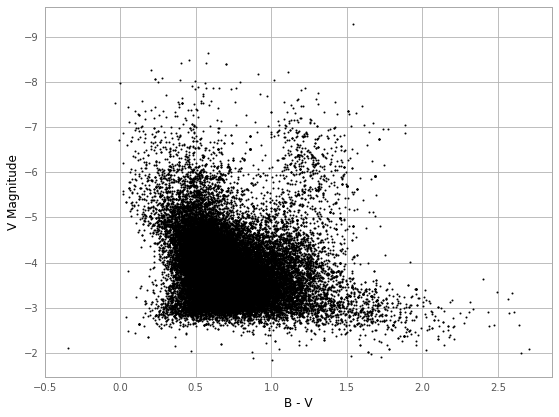

In [3]:
ravetable = QTable.read('NEW_rave_tgas_query_incl_bvmag.csv', format='csv')
bmag = ravetable['BTmag_TYCHO2']
vmag = ravetable['VTmag_TYCHO2']
bv = bmag - vmag


fig,ax = plt.subplots(1,1)
fig.tight_layout()
fig.set_size_inches(8,6)

ax.set_xlabel("B - V")
ax.set_ylabel("V Magnitude")
ax.invert_yaxis()
    
ax.plot(bv, (vmag - 5 * (np.log10(7000)-1)), color='k', marker='o', markersize=1, linestyle='None')
plt.show()